# TIME SERIES FORECASTING OF PROJECT TWEETS BIG DATA PROCESSED WITH SPARK AND STORED IN MONGODB

# Dataset
The dataste is a large dataset gleaned from the twitter API that is called ProjectTweets.csv.

This dataset contains 1,600,000 tweets extracted using the twitter api. 


Content
It contains the following 5 fields:
- ids: The id of the tweet (eg. 4587)
- date: the date of the tweet (eg. Sat May 16 23:58:44 UTC 2009)
- flag: The query (eg. lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (eg. bobthebuilder)
- text: the text of the tweet (eg. Lyx is cool)

## Install all Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col, lower, regexp_replace, trim, split, udf
from pyspark.sql.functions import isnull, to_timestamp
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StringType, TimestampType
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
# Creating a pyspark session connecting to mongodb
uri = "mongodb://172.17.0.8:27017/dianaCATwo.Tweets"

spark = SparkSession.builder.appName("Write into MongoDB")\
    .config("spark.mongodb.input.uri", uri)\
    .config("spark.mongodb.output.uri", uri)\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
    .getOrCreate()

In [3]:
spark

# Working with MongoDB Using SPark for Processing and Storing Project Tweets Dataset
- Processing data in MongoDB involves performing the CRUD operations. This include:-
- Creating/Inserting data in MongoDB
- -Reading data from MongoDB
- Updating data in MongoDB
- Deleting data from MongoDB
All this operations are performed by spark
- After all this operations the processed data can be stored as a pandas/csv for further analysis

## Loading data from local machine to SParkSQL

In [4]:
# Set legacy timeParserPolicy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Define the schema for the csv file 
schema = StructType().add("_c0", StringType(), True).add("_c1", StringType(), True).add("_c2", StringType(), True).add("_c3", StringType(), True).add("_c4", StringType(), True).add("_c5", StringType(), True)

# Read the CSV into a DataFrame called df
df = spark.read.format("csv").option("header", False).schema(schema).load("file:///home/jovyan/Diana/ProjectTweets.csv")

# Rename the headers
df = df.withColumnRenamed("_c0", "PRIMARY KEY").withColumnRenamed("_c1", "ID").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

# Convert string date to TimestampType
df = df.withColumn("date", to_timestamp(df["date"], "EEE MMM dd HH:mm:ss zzzz yyyy"))

# Print schema
df.printSchema()

# Show DataFrame
df.show(5)


root
 |-- PRIMARY KEY: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+-----------+----------+-------------------+--------+---------------+--------------------+
|PRIMARY KEY|        ID|               date|    flag|           user|                text|
+-----------+----------+-------------------+--------+---------------+--------------------+
|          0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|          1|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|          2|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|          3|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|          4|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
+-----------+----------+------------------

# PERFORMING CRUD OPERATIONS

## Step One: Creating/Inserting the project tweets data from spark to MongoDB

In [5]:
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", uri).save()

## Step Two: Reading/loading the Project tweets Data from MongoDB to SparkSQL Dataframe

In [6]:
from_mongo = spark.read.format('com.mongodb.spark.sql.DefaultSource').load()
print((from_mongo.count(), len(from_mongo.columns)))
from_mongo.printSchema()
from_mongo.show(5)

(1600000, 7)
root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)

+----------+-----------+--------------------+-------------------+--------+--------------------+------------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|        user|
+----------+-----------+--------------------+-------------------+--------+--------------------+------------+
|1990436550|    1223636|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|        kmdk|
|1990436582|    1223637|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|jflinchbaugh|
|1990436614|    1223638|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|   kittaykat|
|1990436651|    1223639|{664

# EXPLORATORY DATA ANALYSIS
EDA involved, the follwoing:-
- Checking for duplicates
- Checking for Missing data/dates

## i) Checking for Duplicates (based on ID, user and text)

In [7]:
from pyspark.sql.functions import col

#Check for duplicates based on user, date, and text
duplicates = df.groupBy("user", "date", "text").count().where(col("count") > 1)

if duplicates.count() > 0:
    print("Duplicate rows based on user, date, and text:")
    duplicates.show()
else:
    print("No duplicates found.")

Duplicate rows based on user, date, and text:
+---------------+-------------------+--------------------+-----+
|           user|               date|                text|count|
+---------------+-------------------+--------------------+-----+
|    corewarrior|2009-05-18 14:15:43|#Chuck: Renewed! ...|    2|
|   vanillabelle|2009-06-01 08:51:08|Wifi net connecti...|    2|
| nyc_specialist|2009-06-06 14:17:20|@conchordgirl he ...|    2|
|         jtjazz|2009-04-20 13:04:33|@goodenufmother  ...|    2|
|       rdawkins|2009-04-20 14:34:42|Finally awake. Go...|    2|
|         _maisy|2009-05-02 11:52:06|@lil_stephanie co...|    2|
|     VixieManic|2009-05-10 13:58:39|Hopes you feel be...|    2|
|        MsKelz7|2009-05-17 08:10:16|@RunwayJ I defini...|    2|
|  Jeff_Hardyfan|2009-06-01 10:18:25|&quot;@mileycyrus...|    2|
|PARISnHOLLYWOOD|2009-06-06 06:15:14|@OGOchoCinco okok...|    2|
|  SweetestSin_S|2009-04-19 07:53:24|goodmorning every...|    2|
|       HEYtasha|2009-04-19 16:10:16|watchin

In [8]:
#Count the total number of duplicates
total_duplicates = duplicates.count()

In [9]:
#Print the number of duplicates
print(total_duplicates)

1865


## ii) Checking for missing data
Checking missing data involves:-
- checking if the dates have any missing dates
- check if the other variables have missing data

### Checking missing dates

In [10]:
from pyspark.sql.functions import col, date_format
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

#Find min and max dates
min_date = df.selectExpr("min(date)").first()[0]
max_date = df.selectExpr("max(date)").first()[0]

#Generate DataFrame with all dates within the range
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
date_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

# Left join with the original DataFrame to find missing dates
missing_dates_df = date_df.join(df, "date", "left_anti")

missing_dates_count = missing_dates_df.count()

if missing_dates_count > 0:
    print("Number of missing dates:", missing_dates_count)
    print("Actual missing dates:")
    missing_dates_df.show()
else:
    print("No missing dates found.")


Number of missing dates: 72
Actual missing dates:
+-------------------+
|               date|
+-------------------+
|2009-04-10 05:19:45|
|2009-04-25 05:19:45|
|2009-05-05 05:19:45|
|2009-05-06 05:19:45|
|2009-05-09 05:19:45|
|2009-05-28 05:19:45|
|2009-05-30 05:19:45|
|2009-06-01 05:19:45|
|2009-06-04 05:19:45|
|2009-06-18 05:19:45|
|2009-06-22 05:19:45|
|2009-04-08 05:19:45|
|2009-04-15 05:19:45|
|2009-04-19 05:19:45|
|2009-04-23 05:19:45|
|2009-04-24 05:19:45|
|2009-04-28 05:19:45|
|2009-04-30 05:19:45|
|2009-05-01 05:19:45|
|2009-05-12 05:19:45|
+-------------------+
only showing top 20 rows



In [11]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

# Define start date and end date
start_date = datetime.strptime("2009-04-01", "%Y-%m-%d").date()
end_date = datetime.strptime("2009-06-30", "%Y-%m-%d").date()

# Generate DataFrame with all dates within the range
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
date_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

# Left join with the original DataFrame to find missing dates
missing_dates_df = date_df.join(df, "date", "left_anti")

missing_dates_count = missing_dates_df.count()

if missing_dates_count > 0:
    print("Number of missing dates:", missing_dates_count)
    print("Actual missing dates:")
    missing_dates_df.show()
else:
    print("No missing dates found.")


Number of missing dates: 85
Actual missing dates:
+----------+
|      date|
+----------+
|2009-04-10|
|2009-04-13|
|2009-04-17|
|2009-04-18|
|2009-04-21|
|2009-04-26|
|2009-04-27|
|2009-04-28|
|2009-05-07|
|2009-05-11|
|2009-05-14|
|2009-05-15|
|2009-05-17|
|2009-05-18|
|2009-05-20|
|2009-05-21|
|2009-05-23|
|2009-05-24|
|2009-05-26|
|2009-05-27|
+----------+
only showing top 20 rows



# EXTRACTING TIME COMPONENTS

In [12]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second


#Initialize Spark Session
spark = SparkSession.builder.appName("DateTime Visualization").getOrCreate()

# Extract relevant time components including hours, minutes, and seconds
df = from_mongo.withColumn("year", year("date")).withColumn("month", month("date")).withColumn("day", dayofmonth("date")).withColumn("hour", hour("date")).withColumn("minute", minute("date")).withColumn("second", second("date"))

# Aggregate data
time_series_data = df.groupBy("date","year", "month", "day", "hour", "minute", "second").count().orderBy("year", "month", "day", "hour", "minute", "second")

In [13]:
#View the df DataFrame after extracting time components
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|        user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|1990436550|    1223636|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|        kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|jflinchbaugh|2009|    6|  1|  11|    52|     3|
|1990436614|    1223638|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|   kittaykat|2009|    6|  1|  11|    52|     4|
|1990436651|    1223639|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|       Mm_Ka|2009|    6|  1|  11|    52|     4|

In [14]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



In [15]:
from pyspark.sql.functions import count

# Group by the year variable and count the occurrences
year_counts = df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

# Show the tabulated counts
year_counts.show()

+----+-------+
|year|  count|
+----+-------+
|2009|1600000|
+----+-------+



In [16]:
from pyspark.sql.functions import count

# Group by the month variable and count the occurrences
month_counts = df.groupBy("month").agg(count("*").alias("count")).orderBy("month")

# Show the tabulated counts
month_counts.show()

+-----+------+
|month| count|
+-----+------+
|    4|100025|
|    5|559073|
|    6|940902|
+-----+------+



In [17]:
from pyspark.sql.functions import count

# Group by month and day and count the occurrences
month_day_counts = df.groupBy("month", "day").agg(count("*").alias("count")).orderBy("month", "day")

# Show the tabulated counts
month_day_counts.show()

+-----+---+------+
|month|day| count|
+-----+---+------+
|    4|  7| 20671|
|    4| 18| 17154|
|    4| 19| 32648|
|    4| 20| 18447|
|    4| 21| 11105|
|    5|  2| 31096|
|    5|  3| 26568|
|    5|  4| 28300|
|    5| 10| 31551|
|    5| 11|  6217|
|    5| 12|  4186|
|    5| 14| 21526|
|    5| 17| 41205|
|    5| 18| 44564|
|    5| 22| 41206|
|    5| 24|   169|
|    5| 25|   169|
|    5| 27| 11619|
|    5| 29| 60227|
|    5| 30|104484|
+-----+---+------+
only showing top 20 rows



In [18]:
#Check the df type
type(df)

pyspark.sql.dataframe.DataFrame

In [19]:
#Check the first 5 observations
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|        user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+------------+----+-----+---+----+------+------+
|1990436550|    1223636|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|        kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{6640f2c548788c04...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|jflinchbaugh|2009|    6|  1|  11|    52|     3|
|1990436614|    1223638|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|   kittaykat|2009|    6|  1|  11|    52|     4|
|1990436651|    1223639|{6640f2c548788c04...|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|       Mm_Ka|2009|    6|  1|  11|    52|     4|

In [20]:
#Drop the _id, ID and PRIMARY KEY
df = df.drop("_id", "ID", "PRIMARY KEY")

In [21]:
#Check if they variables have been dropped
df.show()

+-------------------+--------+--------------------+--------------+----+-----+---+----+------+------+
|               date|    flag|                text|          user|year|month|day|hour|minute|second|
+-------------------+--------+--------------------+--------------+----+-----+---+----+------+------+
|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|          kmdk|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|  jflinchbaugh|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|     kittaykat|2009|    6|  1|  11|    52|     4|
|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|         Mm_Ka|2009|    6|  1|  11|    52|     4|
|2009-06-01 11:52:04|NO_QUERY|@nickayre Lol. Bu...|   bryancheung|2009|    6|  1|  11|    52|     4|
|2009-06-01 11:52:05|NO_QUERY|I love it when I ...|     videohive|2009|    6|  1|  11|    52|     5|
|2009-06-01 11:52:05|NO_QUERY|http://twitpic.co...|    kayepintac|2009|    6|  1|  11|    5

# Step Three: Update the Processed data in MongoDB


In [22]:
#Write the processed df to MongoDB (overwrite mode to update existing data)
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").option("uri", uri).save()

# Step Four: Delete data from MongoDB

In [23]:
#Drop the year from the df
variable_to_delete = "year"
df = df.drop(variable_to_delete)

#Write the modified df back to MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").option("uri", uri).save()

# Save the df Dataframe as a Pandas

In [24]:
data = df.collect()

In [25]:
#import pandas as pd
#Create pandas DataFrame from the list of rows
pandas_df = pd.DataFrame(data)

In [26]:
pandas_df.columns = df.columns 

In [27]:
#file path where you want to save the CSV file
file_path = "pandas_data.csv"

# Save the DataFrame to a CSV file
pandas_df.to_csv(file_path)

# SENTIMENT ANALYSIS COMPARING VADER VS TEXTBLOB, THEN TIME SERIES FORECASTING

## Text/Tweets Analysis
This includes the following steps:-
- Read and Load the Dataset
- Exploratory Data Analysis
- Data Visualization of Target Variables
- Data Preprocessing
- Splitting our data into Train and Test sets.
- Transforming Dataset using TF-IDF Vectorizer
- Function for Model Evaluation
- Model Building
- Model Evaluation

# Read the pandas_data as a csv

In [1]:
import pandas as pd

#Load the data
df = pd.read_csv("C:/Users/Diana/Documents/Semester 2/sem two ca 2/pandas_data.csv")

## Exploratory Data Analysis

This process involves:-

a) View the first and last few observations of the df dataframe

b) View the number of observations and variables the df dataframe has

c) View the entire df dataframe to check the data types and any missing data in a particluar variable.
 
d) Checking for missing data/dates


In [2]:
#View the first few observations of the df DataFrame
df.head(5)

Unnamed: 0                 date      flag  \
0           0  2009-04-18 15:51:40  NO_QUERY   
1           1  2009-06-07 00:02:45  NO_QUERY   
2           2  2009-06-01 11:52:03  NO_QUERY   
3           3  2009-06-01 11:52:03  NO_QUERY   
4           4  2009-06-01 11:52:04  NO_QUERY   

                                                text           user  year  \
0        @ctribe I hope you are having a great day.   prosario_2000  2009   
1  Kinda scared to sleep alone in this house toni...          l7l7v  2009   
2  @karinhoegh  Didn't think of national holidays...           kmdk  2009   
3  Need more FPS....time to shop for a new camera...   jflinchbaugh  2009   
4                   @SteveOGallagher take me with u       kittaykat  2009   

   month  day  hour  minute  second  
0      4   18    15      51      40  
1      6    7     0       2      45  
2      6    1    11      52       3  
3      6    1    11      52       3  
4      6    1    11      52       4

In [3]:
#View the last few observations of the df DataFrame
df.tail(5)

Unnamed: 0                 date      flag  \
1599995     1599995  2009-06-07 00:02:36  NO_QUERY   
1599996     1599996  2009-06-07 00:02:40  NO_QUERY   
1599997     1599997  2009-06-07 00:02:41  NO_QUERY   
1599998     1599998  2009-06-07 00:02:41  NO_QUERY   
1599999     1599999  2009-06-07 00:02:41  NO_QUERY   

                                                      text            user  \
1599995  I just got a bunch of money for graduation, bu...      chichi7391   
1599996                                    were is my pic   lambrinilesley   
1599997     @sar_88 you had to wait 2 hours for the foood        sweetmash   
1599998  @pollyyy by the way i hate you for seeing bran...   LittleBirkett   
1599999  Not looking forward to a good 9 hours at One P...     paul_hauffe   

         year  month  day  hour  minute  second  
1599995  2009      6    7     0       2      36  
1599996  2009      6    7     0       2      40  
1599997  2009      6    7     0       2      41  
1599998  2009      6    7     0       2      41  
1599999  2009      6    7     0       2      41

In [4]:
#View the shape of the df DataFrame
df.shape

(1600000, 11)

In [5]:
#View the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1600000 non-null  int64 
 1   date        1600000 non-null  object
 2   flag        1600000 non-null  object
 3   text        1600000 non-null  object
 4   user        1600000 non-null  object
 5   year        1600000 non-null  int64 
 6   month       1600000 non-null  int64 
 7   day         1600000 non-null  int64 
 8   hour        1600000 non-null  int64 
 9   minute      1600000 non-null  int64 
 10  second      1600000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 134.3+ MB


In [6]:
# Convert the 'date_column' to datetime datatype
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Check if the date has been changed to date time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Unnamed: 0  1600000 non-null  int64         
 1   date        1600000 non-null  datetime64[ns]
 2   flag        1600000 non-null  object        
 3   text        1600000 non-null  object        
 4   user        1600000 non-null  object        
 5   year        1600000 non-null  int64         
 6   month       1600000 non-null  int64         
 7   day         1600000 non-null  int64         
 8   hour        1600000 non-null  int64         
 9   minute      1600000 non-null  int64         
 10  second      1600000 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 134.3+ MB


## Drop Variables that will not be used

In [8]:
# Drop all columns except 'date' and 'text'
df = df[['date', 'text','user','day','month']]

In [9]:
#Check if they have been dropped
df.head(5)

date                                               text  \
0 2009-04-18 15:51:40        @ctribe I hope you are having a great day.    
1 2009-06-07 00:02:45  Kinda scared to sleep alone in this house toni...   
2 2009-06-01 11:52:03  @karinhoegh  Didn't think of national holidays...   
3 2009-06-01 11:52:03  Need more FPS....time to shop for a new camera...   
4 2009-06-01 11:52:04                   @SteveOGallagher take me with u    

            user  day  month  
0  prosario_2000   18      4  
1          l7l7v    7      6  
2           kmdk    1      6  
3   jflinchbaugh    1      6  
4      kittaykat    1      6

In [10]:
# Sort the DataFrame by the 'date' column in ascending order
df = df.sort_values(by='date', ascending=True)

In [11]:
#Check if the date is sorted
df.head(5)

date                                               text  \
271 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
275 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
277 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
279 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
281 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

                user  day  month  
271  _TheSpecialOne_    7      4  
275    scotthamilton    7      4  
277         mattycus    7      4  
279          ElleCTF    7      4  
281           Karoli    7      4

In [12]:
#Reset the index
df = df.reset_index(drop=True)

In [13]:
#Check if the index has been reset
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  
0  _TheSpecialOne_    7      4  
1    scotthamilton    7      4  
2         mattycus    7      4  
3          ElleCTF    7      4  
4           Karoli    7      4

In [14]:
#Group by month and find minimum and maximum date for each month
monthly_date_range = df.groupby('month')['date'].agg([min, max])

#Display the result
print(monthly_date_range)

                      min                 max
month                                        
4     2009-04-07 05:19:45 2009-04-21 11:22:15
5     2009-05-02 03:08:46 2009-05-31 23:59:59
6     2009-06-01 00:00:00 2009-06-25 17:28:31


## The dates have some missing dates
- The data is for 3 months, April, May, June
- April (7/4/2009 - 21/4/2009)
- May (2/5/2009) - 31/5/2009
- June (1/6/2009 -25/6/2009)

## EDA OF DATE VARIABLE

In [15]:
df['date'].describe()

C:\Users\Diana\AppData\Local\Temp\ipykernel_20992\801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                 1600000
unique                 774363
top       2009-06-15 19:53:14
freq                       20
first     2009-04-07 05:19:45
last      2009-06-25 17:28:31
Name: date, dtype: object

## Findings
The first date is 7/4/2009 and the last dat is 25/06/2009

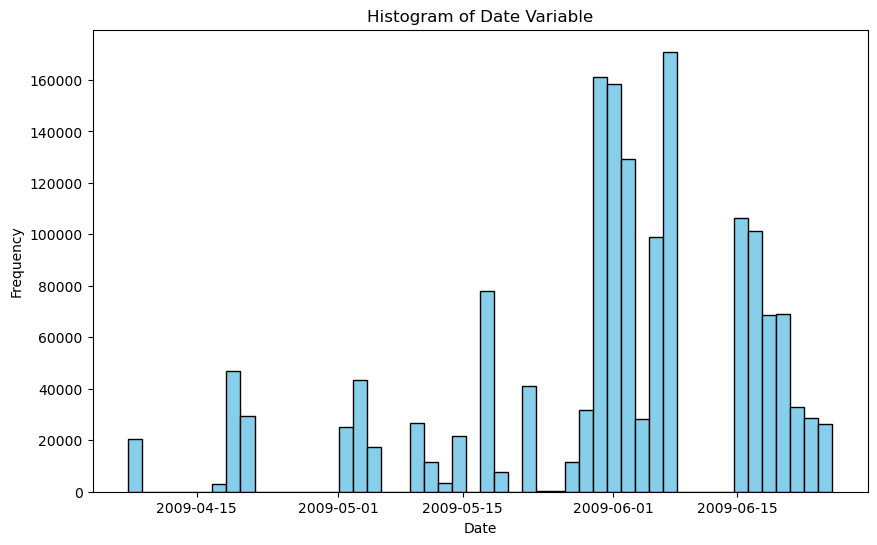

In [16]:
#Histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['date'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Date Variable')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

## Findings
There are missing days 

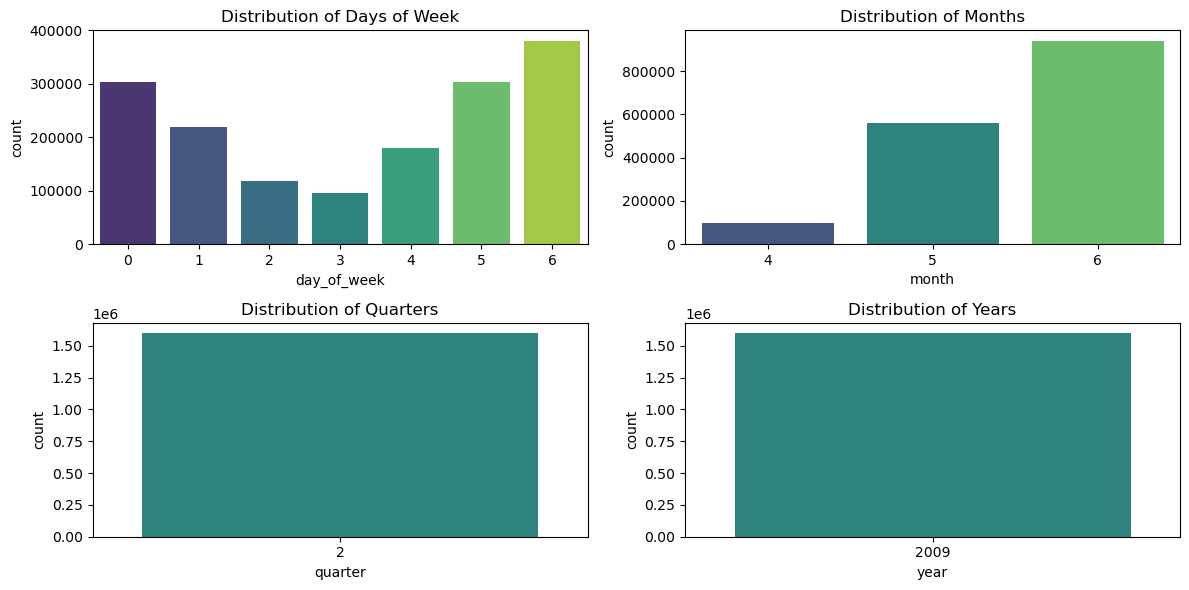

In [17]:
import seaborn as sns
#Extract additional date features for analysis
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

# Plotting distribution of date features
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.countplot(x='day_of_week', data=df, palette='viridis')
plt.title('Distribution of Days of Week')

plt.subplot(2, 2, 2)
sns.countplot(x='month', data=df, palette='viridis')
plt.title('Distribution of Months')

plt.subplot(2, 2, 3)
sns.countplot(x='quarter', data=df, palette='viridis')
plt.title('Distribution of Quarters')

plt.subplot(2, 2, 4)
sns.countplot(x='year', data=df, palette='viridis')
plt.title('Distribution of Years')

plt.tight_layout()
plt.show()

In [18]:
# Extract month from date
df['month'] = df['date'].dt.month

# Group by month and extract sequences
sequences_by_month = {}
for month, group in df.groupby('month'):
    sequences = []
    current_sequence = []
    prev_date = None
    for date in group['date']:
        if prev_date is None or (date - prev_date).days == 1:
            current_sequence.append(date)
        else:
            if len(current_sequence) > 1:
                sequences.append(tuple(current_sequence))  # Convert list to tuple
            current_sequence = [date]
        prev_date = date
    if len(current_sequence) > 1:
        sequences.append(tuple(current_sequence))  # Convert list to tuple
    sequences_by_month[month] = sequences

# Find common sequences among the months
common_sequences = None
for month_sequences in sequences_by_month.values():
    if common_sequences is None:
        common_sequences = set(month_sequences)
    else:
        common_sequences.intersection_update(month_sequences)

# Filter sequences with no missing days
common_sequences_no_missing = []
for seq in common_sequences:
    if pd.date_range(start=seq[0], end=seq[-1]).tolist() == list(seq):  # Convert tuple back to list
        common_sequences_no_missing.append(seq)

# Visualize or return common sequences without missing days
print("Common sequences among all months without missing days:")
for seq in common_sequences_no_missing:
    print(seq)

Common sequences among all months without missing days:


In [19]:
import pandas as pd

#Define date range with correct formatting
date_range = pd.date_range(start="2009-04-07", end="2009-06-25", freq="D")

#Find missing dates
missing_dates = date_range[~date_range.isin(df.index)]
print(missing_dates)
print(len(missing_dates))

DatetimeIndex(['2009-04-07', '2009-04-08', '2009-04-09', '2009-04-10',
               '2009-04-11', '2009-04-12', '2009-04-13', '2009-04-14',
               '2009-04-15', '2009-04-16', '2009-04-17', '2009-04-18',
               '2009-04-19', '2009-04-20', '2009-04-21', '2009-04-22',
               '2009-04-23', '2009-04-24', '2009-04-25', '2009-04-26',
               '2009-04-27', '2009-04-28', '2009-04-29', '2009-04-30',
               '2009-05-01', '2009-05-02', '2009-05-03', '2009-05-04',
               '2009-05-05', '2009-05-06', '2009-05-07', '2009-05-08',
               '2009-05-09', '2009-05-10', '2009-05-11', '2009-05-12',
               '2009-05-13', '2009-05-14', '2009-05-15', '2009-05-16',
               '2009-05-17', '2009-05-18', '2009-05-19', '2009-05-20',
               '2009-05-21', '2009-05-22', '2009-05-23', '2009-05-24',
               '2009-05-25', '2009-05-26', '2009-05-27', '2009-05-28',
               '2009-05-29', '2009-05-30', '2009-05-31', '2009-06-01',
      

In [20]:
# Count the number of dates by month
monthly_date_counts = df.groupby('month').size()

# Display the result
print(monthly_date_counts)


month
4    100025
5    559073
6    940902
dtype: int64


In [21]:
#View the df
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  
0  _TheSpecialOne_    7      4            1        2  2009  
1    scotthamilton    7      4            1        2  2009  
2         mattycus    7      4            1        2  2009  
3          ElleCTF    7      4            1        2  2009  
4           Karoli    7      4            1        2  2009

## Visualize the count of each day

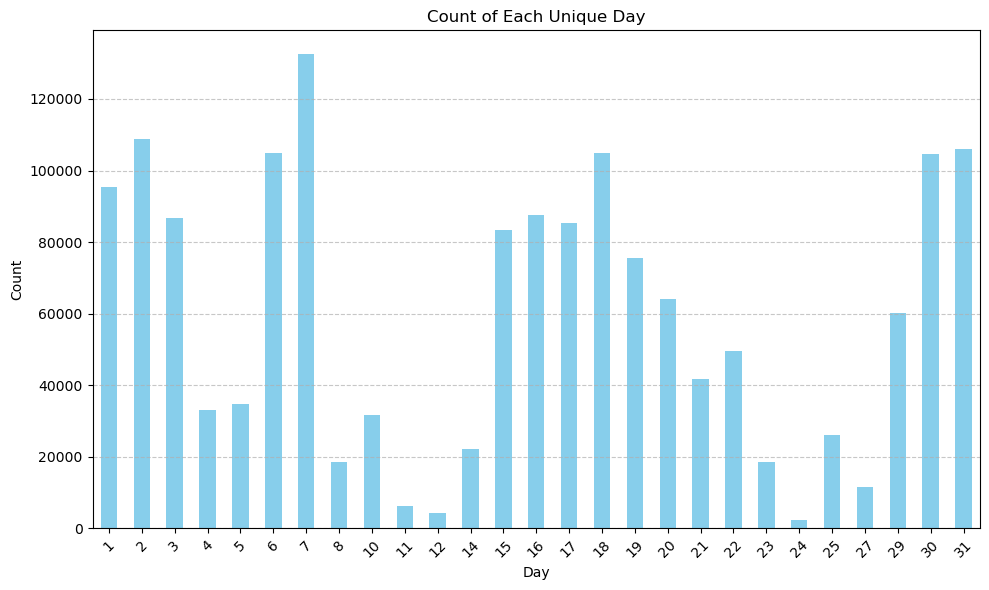

In [22]:
import matplotlib.pyplot as plt
#plot the graph of the days
sorted_days = df['day'].value_counts().sort_index()

# Plotting count of each unique day
plt.figure(figsize=(10, 6))
sorted_days.plot(kind='bar', color='skyblue')
plt.title('Count of Each Unique Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
#Group by month and count the frequency of each unique date within each month
unique_dates_by_month = df.groupby('month')['date'].value_counts()

#Display the result
print(unique_dates_by_month)

month  date               
4      2009-04-18 04:57:42    12
       2009-04-19 00:14:13    11
       2009-04-19 04:22:31    11
       2009-04-19 15:34:51    11
       2009-04-19 17:50:35    11
                              ..
6      2009-06-25 17:28:18     1
       2009-06-25 17:28:19     1
       2009-06-25 17:28:22     1
       2009-06-25 17:28:24     1
       2009-06-25 17:28:31     1
Name: date, Length: 774363, dtype: int64


## Check for duplicates based on date, user and text

In [24]:
import pandas as pd

# Check for duplicates based on user, date, and text
duplicates = df.duplicated(subset=['user', 'date', 'text'], keep=False)

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = df[duplicates]

print("Duplicate rows based on user, date, and text:")
print(duplicate_rows)

Duplicate rows based on user, date, and text:
                       date  \
474     2009-04-07 05:33:35   
480     2009-04-07 05:33:35   
575     2009-04-07 05:38:04   
577     2009-04-07 05:38:04   
2267    2009-04-07 06:28:09   
...                     ...   
1570440 2009-06-23 23:11:03   
1591655 2009-06-25 13:26:14   
1591656 2009-06-25 13:26:14   
1592527 2009-06-25 13:51:59   
1592528 2009-06-25 13:51:59   

                                                      text           user  \
474      Awwh babs... you look so sad underneith that s...       DjGundam   
480      Awwh babs... you look so sad underneith that s...       DjGundam   
575      Haven't tweeted nearly all day  Posted my webs...        iCalvin   
577      Haven't tweeted nearly all day  Posted my webs...        iCalvin   
2267     @hellobebe I also send some updates in plurk b...    mariejamora   
...                                                    ...            ...   
1570440  I effin locked my keys in my hous

# DATA PREPARATION

## Drop Duplicates

In [25]:
#Drop duplicates based on user, text, and date
df = df.drop_duplicates(subset=['user', 'text', 'date'])

print("DataFrame after dropping duplicates based on user, text, and date:")
df

DataFrame after dropping duplicates based on user, text, and date:


date  \
0       2009-04-07 05:19:45   
1       2009-04-07 05:19:49   
2       2009-04-07 05:19:53   
3       2009-04-07 05:19:57   
4       2009-04-07 05:19:57   
...                     ...   
1599995 2009-06-25 17:28:28   
1599996 2009-06-25 17:28:28   
1599997 2009-06-25 17:28:30   
1599998 2009-06-25 17:28:30   
1599999 2009-06-25 17:28:31   

                                                      text             user  \
0        @switchfoot http://twitpic.com/2y1zl - Awww, t...  _TheSpecialOne_   
1        is upset that he can't update his Facebook by ...    scotthamilton   
2        @Kenichan I dived many times for the ball. Man...         mattycus   
3          my whole body feels itchy and like its on fire           ElleCTF   
4        @nationwideclass no, it's not behaving at all....           Karoli   
...                                                    ...              ...   
1599995  Sick  Spending my day laying in bed listening ...         dandykim   
1599996                                    Gmail is down?           bigenya   
1599997                      rest in peace Farrah! So sad          LeeLHoke   
1599998  @Eric_Urbane Sounds like a rival is flagging y...     davidlmulder   
1599999  has to resit exams over summer...  wishes he w...       tpchandler   

         day  month  day_of_week  quarter  year  
0          7      4            1        2  2009  
1          7      4            1        2  2009  
2          7      4            1        2  2009  
3          7      4            1        2  2009  
4          7      4            1        2  2009  
...      ...    ...          ...      ...   ...  
1599995   25      6            3        2  2009  
1599996   25      6            3        2  2009  
1599997   25      6            3        2  2009  
1599998   25      6            3        2  2009  
1599999   25      6            3        2  2009  

[1598127 rows x 8 columns]

In [26]:
#Check size of dataset after dropping duplicates
df.shape

(1598127, 8)

In [27]:
#Check if the duplicates based on user, date, and text have been dropped
duplicates = df.duplicated(subset=['user', 'date', 'text'], keep=False)

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = df[duplicates]

print("Duplicate rows based on user, date, and text:")
print(duplicate_rows)

Duplicate rows based on user, date, and text:
Empty DataFrame
Columns: [date, text, user, day, month, day_of_week, quarter, year]
Index: []


## Findings
Duplicates have been dropped.

In [28]:
#Check for Null Rows
df.isnull().sum()

date           0
text           0
user           0
day            0
month          0
day_of_week    0
quarter        0
year           0
dtype: int64

In [29]:
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  
0  _TheSpecialOne_    7      4            1        2  2009  
1    scotthamilton    7      4            1        2  2009  
2         mattycus    7      4            1        2  2009  
3          ElleCTF    7      4            1        2  2009  
4           Karoli    7      4            1        2  2009

In [30]:
#reset the index after dropping duplicates
df = df.reset_index(drop=True)

# EDA of the Texts

In [31]:
#Count the number of words in the text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [32]:
df[["text","word_count"]].head(5)

text  word_count
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          20
1  is upset that he can't update his Facebook by ...          22
2  @Kenichan I dived many times for the ball. Man...          19
3    my whole body feels itchy and like its on fire           11
4  @nationwideclass no, it's not behaving at all....          22

In [33]:
#Find the maximum number of words in the 'word_count' variable of the 'df' DataFrame
largest_word_count = df["word_count"].max()
largest_word_count

110

In [34]:
#Count the number of characters in the text variable
df['char_count'] = df['text'].str.len() 

In [35]:
#View the head of the char_count and text
df[["text","char_count"]].head(5)

text  char_count
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...         115
1  is upset that he can't update his Facebook by ...         111
2  @Kenichan I dived many times for the ball. Man...          89
3    my whole body feels itchy and like its on fire           47
4  @nationwideclass no, it's not behaving at all....         111

In [36]:
#Find the maximum number of characters in the 'char_count' variable of the 'df' DataFrame
largest_char_count = df["char_count"].max()
largest_char_count

374

In [37]:
#define a function to calculate the average length of words in a sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [38]:
#Apply the avg_word function on text
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

In [39]:
#View text and avg_word
df[['text','avg_word']].head()

text  avg_word
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  5.052632
1  is upset that he can't update his Facebook by ...  4.285714
2  @Kenichan I dived many times for the ball. Man...  3.944444
3    my whole body feels itchy and like its on fire   3.700000
4  @nationwideclass no, it's not behaving at all....  4.285714

In [40]:
#Find the highest average word count of the 'df' DataFrame
highest_avg_word = df["avg_word"].max()
highest_avg_word

137.0

In [41]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [42]:
#count number of stopwords in each text and store in a variable called stopwords
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head(5)

text  stopwords
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          4
1  is upset that he can't update his Facebook by ...          8
2  @Kenichan I dived many times for the ball. Man...          5
3    my whole body feels itchy and like its on fire           4
4  @nationwideclass no, it's not behaving at all....         10

In [43]:
#Find the maximum number of stopwords in the 'df' DataFrame
maximum_no_stopwords = df["stopwords"].max()
maximum_no_stopwords

25

In [44]:
#Count number of hashtags in each text and store in a variable called hastags
df['hashtags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text','hashtags']].head(5)

text  hashtags
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...         0
1  is upset that he can't update his Facebook by ...         0
2  @Kenichan I dived many times for the ball. Man...         0
3    my whole body feels itchy and like its on fire          0
4  @nationwideclass no, it's not behaving at all....         0

In [45]:
#Find the maximum number of hashtags in the 'df' DataFrame
maximum_no_hashtags = df["hashtags"].max()
maximum_no_hashtags

24

In [46]:
#count number of @ signs in text variable and store the value in a variable called at_sign
df['at_sign'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','at_sign']].head(5)

text  at_sign
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...        1
1  is upset that he can't update his Facebook by ...        0
2  @Kenichan I dived many times for the ball. Man...        1
3    my whole body feels itchy and like its on fire         0
4  @nationwideclass no, it's not behaving at all....        1

In [47]:
#Find the maximum number of at_sign in the 'df' DataFrame
maximum_no_atsign = df["at_sign"].max()
maximum_no_atsign

12

In [48]:
#count number of numerics in the text variable and store the value in a variable called numeric
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head(5)

text  numerics
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...         0
1  is upset that he can't update his Facebook by ...         0
2  @Kenichan I dived many times for the ball. Man...         0
3    my whole body feels itchy and like its on fire          0
4  @nationwideclass no, it's not behaving at all....         0

In [49]:
#Find the maximum number of numerics in the 'df' DataFrame
maximum_no_numerics = df["numerics"].max()
maximum_no_numerics

13

In [50]:
#count number of uppercases in the text variable and store the value in a variable called upper
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text','upper']].head(5)

text  upper
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...      1
1  is upset that he can't update his Facebook by ...      0
2  @Kenichan I dived many times for the ball. Man...      1
3    my whole body feels itchy and like its on fire       0
4  @nationwideclass no, it's not behaving at all....      1

In [51]:
#Find the maximum number of uppercases in the 'df' DataFrame
maximum_no_uppercases = df["upper"].max()
maximum_no_uppercases

40

In [52]:
df.isnull().sum()

date           0
text           0
user           0
day            0
month          0
day_of_week    0
quarter        0
year           0
word_count     0
char_count     0
avg_word       0
stopwords      0
hashtags       0
at_sign        0
numerics       0
upper          0
dtype: int64

In [53]:
# Count the duplicate rows in the DataFrame
duplicate_count = df.duplicated().sum()

print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


## Tweets Processing
Tweet/text processing involves:-

a) Text Normalization 
- Remove special characters
- Change the upper cases to lower cases
- Remove numbers/integers
- Remove punctuations
- Remove white space
- Remove URLS/links

b) Tokenization
- Tokenization

c) Remove stopwords

d) Stemming/ lemmatization

## Text Normalization

### Remove user name from text @username

In [54]:
import re

#Define a function to remove user names from text
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

#Apply the function to the 'text' variable
df['text1'] = df['text'].apply(remove_usernames)

# Print the first few rows of the DataFrame with user names removed from text
print(df['text1'].head())


0     http://twitpic.com/2y1zl - Awww, that's a bum...
1    is upset that he can't update his Facebook by ...
2     I dived many times for the ball. Managed to s...
3      my whole body feels itchy and like its on fire 
4     no, it's not behaving at all. i'm mad. why am...
Name: text1, dtype: object


### Remove url/www.links

In [55]:
import re

def remove_urls(df):
    #Define regex pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    #Apply regex substitution to each row of the 'text' column
    df['text1'] = df['text1'].apply(lambda text: re.sub(url_pattern, '', text))
    
    return df

# remove a url
df = remove_urls(df)


In [56]:
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  word_count  \
0  _TheSpecialOne_    7      4            1        2  2009          20   
1    scotthamilton    7      4            1        2  2009          22   
2         mattycus    7      4            1        2  2009          19   
3          ElleCTF    7      4            1        2  2009          11   
4           Karoli    7      4            1        2  2009          22   

   char_count  avg_word  stopwords  hashtags  at_sign  numerics  upper  \
0         115  5.052632          4         0        1         0      1   
1         111  4.285714          8         0        0         0      0   
2          89  3.944444          5         0        1         0      1   
3          47  3.700000          4         0        0         0      0   
4         111  4.285714         10         0        1         0      1   

                                               text1  
0    - Awww, that's a bummer.  You shoulda got Da...  
1  is upset that he can't update his Facebook by ...  
2   I dived many times for the ball. Managed to s...  
3    my whole body feels itchy and like its on fire   
4   no, it's not behaving at all. i'm mad. why am...

### Remove all special characters

In [57]:
#Remove all special characters
df['text1'] = df['text1'].str.replace('[^\w\s]','')
df['text1'].head(5)

C:\Users\Diana\AppData\Local\Temp\ipykernel_20992\1096157190.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text1'] = df['text1'].str.replace('[^\w\s]','')


0       Awww thats a bummer  You shoulda got David ...
1    is upset that he cant update his Facebook by t...
2     I dived many times for the ball Managed to sa...
3      my whole body feels itchy and like its on fire 
4     no its not behaving at all im mad why am i he...
Name: text1, dtype: object

### Remove punctuations

In [58]:
#Remove punctuations
import string

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#Apply remove_punctuation function to the 'text' column
df['text1'] = df['text1'].apply(remove_punctuation)


In [59]:
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  word_count  \
0  _TheSpecialOne_    7      4            1        2  2009          20   
1    scotthamilton    7      4            1        2  2009          22   
2         mattycus    7      4            1        2  2009          19   
3          ElleCTF    7      4            1        2  2009          11   
4           Karoli    7      4            1        2  2009          22   

   char_count  avg_word  stopwords  hashtags  at_sign  numerics  upper  \
0         115  5.052632          4         0        1         0      1   
1         111  4.285714          8         0        0         0      0   
2          89  3.944444          5         0        1         0      1   
3          47  3.700000          4         0        0         0      0   
4         111  4.285714         10         0        1         0      1   

                                               text1  
0     Awww thats a bummer  You shoulda got David ...  
1  is upset that he cant update his Facebook by t...  
2   I dived many times for the ball Managed to sa...  
3    my whole body feels itchy and like its on fire   
4   no its not behaving at all im mad why am i he...

### Convert all upper cases to lower

In [60]:
#Convert all uppercases to lower cases
df['text1'] = df['text1'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text1'].head(5)

0    awww thats a bummer you shoulda got david carr...
1    is upset that he cant update his facebook by t...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: text1, dtype: object

## Handling numerics 

In [61]:
import re
import pandas as pd

#Function to remove numbers from text1
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to remove numbers to the 'text1
df['text1'] = df['text1'].apply(lambda x: remove_numbers(x))
df['text1'].head(5)

0    awww thats a bummer you shoulda got david carr...
1    is upset that he cant update his facebook by t...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: text1, dtype: object

## Tokenization

In [62]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Word Tokenization

In [63]:
from nltk.tokenize import word_tokenize

#Tokenize the text using NLTK's word tokenizer
df['tokenized_text'] = df['text1'].apply(lambda x: ' '.join(word_tokenize(x.lower())))

#Print the first few rows of the DataFrame with tokenized text
df[['text1', 'tokenized_text']].head(5)

text1  \
0  awww thats a bummer you shoulda got david carr...   
1  is upset that he cant update his facebook by t...   
2  i dived many times for the ball managed to sav...   
3     my whole body feels itchy and like its on fire   
4  no its not behaving at all im mad why am i her...   

                                      tokenized_text  
0  awww thats a bummer you shoulda got david carr...  
1  is upset that he cant update his facebook by t...  
2  i dived many times for the ball managed to sav...  
3     my whole body feels itchy and like its on fire  
4  no its not behaving at all im mad why am i her...

## Remove stopwords

In [65]:
from nltk.corpus import stopwords

#Download NLTK resources for the first time
nltk.download('stopwords')

#Get the English stopwords list
stop_words = set(stopwords.words('english'))

#Function to remove stopwords
def remove_stopwords(tokenized_text):
    return ' '.join([word for word in tokenized_text.split() if word.lower() not in stop_words])

#Remove stopwords from the tokenized text column
df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)

# Print the first few rows of the DataFrame with stopwords removed
print(df[['text1', 'tokenized_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               text1  \
0  awww thats a bummer you shoulda got david carr...   
1  is upset that he cant update his facebook by t...   
2  i dived many times for the ball managed to sav...   
3     my whole body feels itchy and like its on fire   
4  no its not behaving at all im mad why am i her...   

                                      tokenized_text  
0  awww thats bummer shoulda got david carr third...  
1  upset cant update facebook texting might cry r...  
2  dived many times ball managed save rest go bounds  
3                   whole body feels itchy like fire  
4                           behaving im mad cant see  


In [66]:
#Create a Frequency Distribution of the tokenized words
#Import Frequency Distribution
from nltk.probability import FreqDist

#Find frequency distribution of tokenized_text
fdist = FreqDist(df['tokenized_text'])

In [67]:
#Check top 5 common words
fdist.most_common(5)

[('', 7083),
 ('thanks', 2334),
 ('thank', 1576),
 ('get followers day using add everyone train pay vip', 1484),
 ('good morning', 1144)]

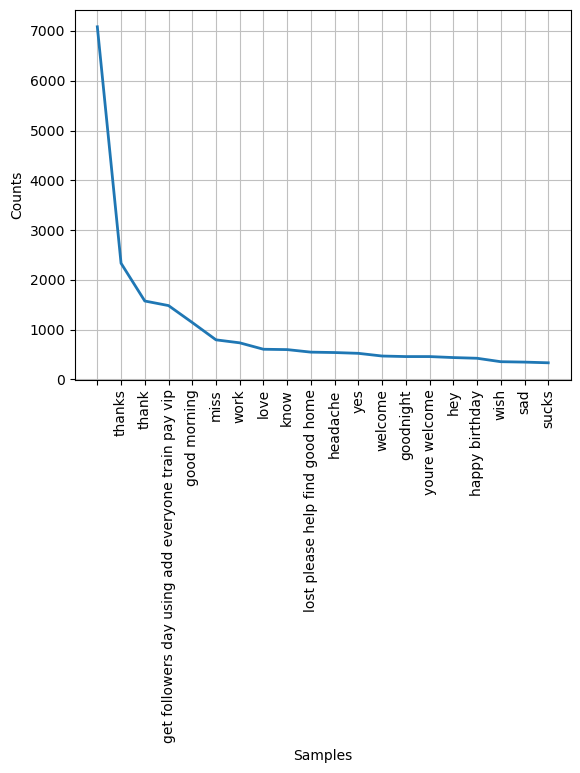

In [68]:
#Create a frequency distribution plot
import matplotlib.pyplot as plt

#Plot Frequency Distribution
fdist.plot(20,cumulative=False)
plt.show()

# Stemming/ lemmatization

In [69]:
from nltk.stem import WordNetLemmatizer

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(tokenized_text):
    #Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokenized_text.split()]
    
    #Join the lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

#Apply lemmatization to 'tokenized_text' column in DataFrame df
df['preprocessed_text'] = df['tokenized_text'].apply(lemmatize_text)

#Print the first few rows of the DataFrame with lemmatized text
print(df[['tokenized_text', 'preprocessed_text']].head(5))

                                      tokenized_text  \
0  awww thats bummer shoulda got david carr third...   
1  upset cant update facebook texting might cry r...   
2  dived many times ball managed save rest go bounds   
3                   whole body feels itchy like fire   
4                           behaving im mad cant see   

                                   preprocessed_text  
0  awww thats bummer shoulda got david carr third...  
1  upset cant update facebook texting might cry r...  
2    dived many time ball managed save rest go bound  
3                    whole body feel itchy like fire  
4                           behaving im mad cant see  


In [70]:
df.isnull().sum()

date                 0
text                 0
user                 0
day                  0
month                0
day_of_week          0
quarter              0
year                 0
word_count           0
char_count           0
avg_word             0
stopwords            0
hashtags             0
at_sign              0
numerics             0
upper                0
text1                0
tokenized_text       0
preprocessed_text    0
dtype: int64

In [71]:
# Count the duplicate rows in the DataFrame
duplicate_count = df.duplicated().sum()

print("Number of duplicate rows:", duplicate_count)


Number of duplicate rows: 0


# SENTIMENT ANALYSIS
There are various ways to perform sentiment analysis. These include:-
- Using Text Blob
- Using Vader
- Using Bag of Words Vectorization-based Models
- Using LSTM-based Models
- Using Transformer-based Models

## USING TEXTBLOB
-  It takes text as an input and can return polarity and subjectivity as outputs.

- Polarity determines the sentiment of the text. Its values lie in [-1,1] where -1 denotes a highly negative sentiment and 1 denotes a highly positive sentiment.

- Subjectivity determines whether a text input is factual information or a personal opinion. Its value lies between [0,1] where a value closer to 0 denotes a piece of factual information and a value closer to 1 denotes a personal opinion.

In [72]:
from textblob import TextBlob

#Apply sentiment analysis using TextBlob to the 'text' column and storing the polarity score
df['polarity_score'] = df['preprocessed_text'].apply(lambda x: TextBlob(x).sentiment[0] )
df[['preprocessed_text','polarity_score']].head(5)

preprocessed_text  polarity_score
0  awww thats bummer shoulda got david carr third...           0.200
1  upset cant update facebook texting might cry r...           0.000
2    dived many time ball managed save rest go bound           0.500
3                    whole body feel itchy like fire           0.200
4                           behaving im mad cant see          -0.625

In [73]:
#View the df, first 5 observations
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  word_count  \
0  _TheSpecialOne_    7      4            1        2  2009          20   
1    scotthamilton    7      4            1        2  2009          22   
2         mattycus    7      4            1        2  2009          19   
3          ElleCTF    7      4            1        2  2009          11   
4           Karoli    7      4            1        2  2009          22   

   char_count  avg_word  stopwords  hashtags  at_sign  numerics  upper  \
0         115  5.052632          4         0        1         0      1   
1         111  4.285714          8         0        0         0      0   
2          89  3.944444          5         0        1         0      1   
3          47  3.700000          4         0        0         0      0   
4         111  4.285714         10         0        1         0      1   

                                               text1  \
0  awww thats a bummer you shoulda got david carr...   
1  is upset that he cant update his facebook by t...   
2  i dived many times for the ball managed to sav...   
3     my whole body feels itchy and like its on fire   
4  no its not behaving at all im mad why am i her...   

                                      tokenized_text  \
0  awww thats bummer shoulda got david carr third...   
1  upset cant update facebook texting might cry r...   
2  dived many times ball managed save rest go bounds   
3                   whole body feels itchy like fire   
4                           behaving im mad cant see   

                                   preprocessed_text  polarity_score  
0  awww thats bummer shoulda got david carr third...           0.200  
1  upset cant update facebook texting might cry r...           0.000  
2    dived many time ball managed save rest go bound           0.500  
3                    whole body feel itchy like fire           0.200  
4                           behaving im mad cant see          -0.625

In [74]:
#View data types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 20 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   date               1598127 non-null  datetime64[ns]
 1   text               1598127 non-null  object        
 2   user               1598127 non-null  object        
 3   day                1598127 non-null  int64         
 4   month              1598127 non-null  int64         
 5   day_of_week        1598127 non-null  int64         
 6   quarter            1598127 non-null  int64         
 7   year               1598127 non-null  int64         
 8   word_count         1598127 non-null  int64         
 9   char_count         1598127 non-null  int64         
 10  avg_word           1598127 non-null  float64       
 11  stopwords          1598127 non-null  int64         
 12  hashtags           1598127 non-null  int64         
 13  at_sign            1598127 

In [75]:
# Function to categorize sentiment polarities
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to classify polarity scores and store the result in 'textblob_sentiment' column
df['textblob_sentiment'] = df['polarity_score'].apply(categorize_sentiment)

# Print the first few rows of the DataFrame with 'textblob_sentiment' column
print(df[['preprocessed_text', 'polarity_score', 'textblob_sentiment']].head())

                                   preprocessed_text  polarity_score  \
0  awww thats bummer shoulda got david carr third...           0.200   
1  upset cant update facebook texting might cry r...           0.000   
2    dived many time ball managed save rest go bound           0.500   
3                    whole body feel itchy like fire           0.200   
4                           behaving im mad cant see          -0.625   

  textblob_sentiment  
0           Positive  
1            Neutral  
2           Positive  
3           Positive  
4           Negative  


# USING VADER SENTIMENT ANALYSIS

In [76]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [77]:
#Create a VADER SentimentIntensityAnalyzer instance
twitter_sentiment = SentimentIntensityAnalyzer()

#Create a function to get compound sentiment score using VADER
def get_sentiment_scores(text):
    return twitter_sentiment.polarity_scores(text)

#Apply the function to get the compound scores and store the values in vader_sentiment
df['vader_sentiment'] = df['preprocessed_text'].apply(get_sentiment_scores)

#Extract the 'neg', 'neu', 'pos', 'compound' scores from 'vader_sentiment'
df['vader_neg'] = df['vader_sentiment'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_sentiment'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_sentiment'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])

#Create a function to categorize sentiments based on compound scores
def categorize_sentiment(vader_compound):
    if vader_compound >= 0.05:
        return 'positive'
    elif vader_compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

#Apply the categorization function to create the 'sentiment' column
df['sentiment_vader'] = df['vader_compound'].apply(categorize_sentiment)

#Display the updated DataFrame with the 'sentiment' column
print(df[['preprocessed_text','vader_compound','sentiment_vader']])

                                         preprocessed_text  vader_compound  \
0        awww thats bummer shoulda got david carr third...         -0.3818   
1        upset cant update facebook texting might cry r...         -0.7269   
2          dived many time ball managed save rest go bound          0.4939   
3                          whole body feel itchy like fire         -0.2500   
4                                 behaving im mad cant see         -0.4939   
...                                                    ...             ...   
1598122             sick spending day laying bed listening         -0.5106   
1598123                                              gmail          0.0000   
1598124                              rest peace farrah sad          0.1027   
1598125           sound like rival flagging ad much though          0.3612   
1598126  resit exam summer wish worked harder first yea...          0.4019   

        sentiment_vader  
0              negative  
1          

In [78]:
#View the first 5 observations
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  word_count  \
0  _TheSpecialOne_    7      4            1        2  2009          20   
1    scotthamilton    7      4            1        2  2009          22   
2         mattycus    7      4            1        2  2009          19   
3          ElleCTF    7      4            1        2  2009          11   
4           Karoli    7      4            1        2  2009          22   

   char_count  ...                                     tokenized_text  \
0         115  ...  awww thats bummer shoulda got david carr third...   
1         111  ...  upset cant update facebook texting might cry r...   
2          89  ...  dived many times ball managed save rest go bounds   
3          47  ...                   whole body feels itchy like fire   
4         111  ...                           behaving im mad cant see   

                                   preprocessed_text  polarity_score  \
0  awww thats bummer shoulda got david carr third...           0.200   
1  upset cant update facebook texting might cry r...           0.000   
2    dived many time ball managed save rest go bound           0.500   
3                    whole body feel itchy like fire           0.200   
4                           behaving im mad cant see          -0.625   

   textblob_sentiment                                    vader_sentiment  \
0            Positive  {'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...   
1             Neutral  {'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...   
2            Positive  {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...   
3            Positive  {'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...   
4            Negative  {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...   

   vader_neg vader_neu vader_pos vader_compound  sentiment_vader  
0      0.245     0.755     0.000        -0.3818         negative  
1      0.441     0.559     0.000        -0.7269         negative  
2      0.000     0.714     0.286         0.4939         positive  
3      0.450     0.300     0.250        -0.2500         negative  
4      0.444     0.556     0.000        -0.4939         negative  

[5 rows x 27 columns]

# Determine which one to use between vader and textblob by evaluating their performance using 

# Using TfidfVectorizer, countvectorizer AND MNB 

### Textblob sentiments

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

#Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))
X = tfidf.fit_transform(df['preprocessed_text'])
y = df['textblob_sentiment']

#Split the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a classifier for MNB
classifier = MultinomialNB()

#Train the Classifier
classifier.fit(X_train, y_train)

#Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.96      0.65      0.77     65410
     Neutral       0.82      0.81      0.82    118744
    Positive       0.78      0.91      0.84    135472

    accuracy                           0.82    319626
   macro avg       0.85      0.79      0.81    319626
weighted avg       0.83      0.82      0.82    319626



# vader sentiment

In [80]:
#Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words='english', ngram_range=(1,1))
X = tfidf.fit_transform(df['preprocessed_text'])
y = df['sentiment_vader']

#Split the data into Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a classifier for MNB
classifier = MultinomialNB()

#Train the Classifier
classifier.fit(X_train, y_train)

#Evaluate the Model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.58      0.70     77131
     neutral       0.75      0.58      0.66     89589
    positive       0.70      0.92      0.80    152906

    accuracy                           0.74    319626
   macro avg       0.78      0.69      0.72    319626
weighted avg       0.76      0.74      0.73    319626



# USING COUNTVECTORIZER

In [81]:
#Pre-Processing using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['text'])

C:\Users\Diana\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## textblob sentiments using count vectorizer

In [82]:
#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['textblob_sentiment'], test_size=0.2, random_state=42)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclate the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

Accuracy Score:  0.8343000882281166


## vader sentiments using count vectorizer

In [83]:
#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['sentiment_vader'], test_size=0.25, random_state=5)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclate the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

Accuracy Score:  0.7684565942152318


## Since the accuracy of sentiments extracted by textblob in both countvectorizer and TDIF is higher sentiments extracted by textblob will be used

In [84]:
#Check the variables data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598127 non-null  datetime64[ns]
 1   text                1598127 non-null  object        
 2   user                1598127 non-null  object        
 3   day                 1598127 non-null  int64         
 4   month               1598127 non-null  int64         
 5   day_of_week         1598127 non-null  int64         
 6   quarter             1598127 non-null  int64         
 7   year                1598127 non-null  int64         
 8   word_count          1598127 non-null  int64         
 9   char_count          1598127 non-null  int64         
 10  avg_word            1598127 non-null  float64       
 11  stopwords           1598127 non-null  int64         
 12  hashtags            1598127 non-null  int64         
 13  at_sign     

# Visualization

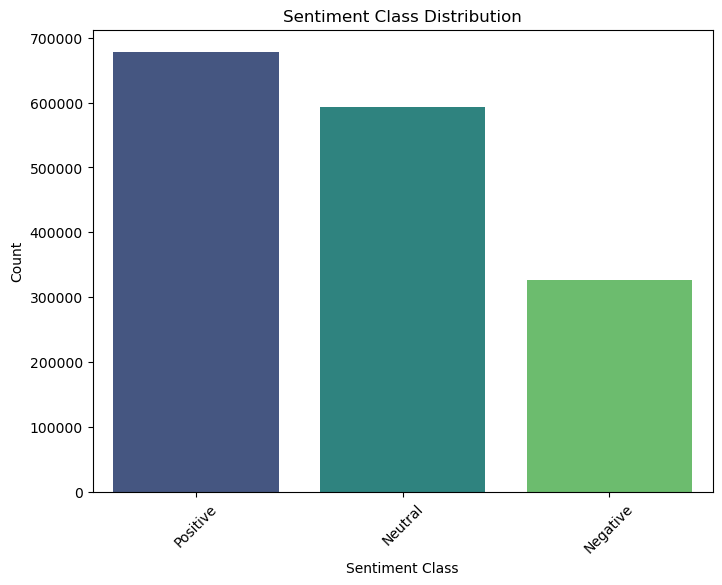

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment class
sentiment_counts = df['textblob_sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [86]:
df.head(5)

date                                               text  \
0 2009-04-07 05:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-07 05:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-07 05:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-07 05:19:57    my whole body feels itchy and like its on fire    
4 2009-04-07 05:19:57  @nationwideclass no, it's not behaving at all....   

              user  day  month  day_of_week  quarter  year  word_count  \
0  _TheSpecialOne_    7      4            1        2  2009          20   
1    scotthamilton    7      4            1        2  2009          22   
2         mattycus    7      4            1        2  2009          19   
3          ElleCTF    7      4            1        2  2009          11   
4           Karoli    7      4            1        2  2009          22   

   char_count  ...                                     tokenized_text  \
0         115  ...  awww thats bummer shoulda got david carr third...   
1         111  ...  upset cant update facebook texting might cry r...   
2          89  ...  dived many times ball managed save rest go bounds   
3          47  ...                   whole body feels itchy like fire   
4         111  ...                           behaving im mad cant see   

                                   preprocessed_text  polarity_score  \
0  awww thats bummer shoulda got david carr third...           0.200   
1  upset cant update facebook texting might cry r...           0.000   
2    dived many time ball managed save rest go bound           0.500   
3                    whole body feel itchy like fire           0.200   
4                           behaving im mad cant see          -0.625   

   textblob_sentiment                                    vader_sentiment  \
0            Positive  {'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...   
1             Neutral  {'neg': 0.441, 'neu': 0.559, 'pos': 0.0, 'comp...   
2            Positive  {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...   
3            Positive  {'neg': 0.45, 'neu': 0.3, 'pos': 0.25, 'compou...   
4            Negative  {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...   

   vader_neg vader_neu vader_pos vader_compound  sentiment_vader  
0      0.245     0.755     0.000        -0.3818         negative  
1      0.441     0.559     0.000        -0.7269         negative  
2      0.000     0.714     0.286         0.4939         positive  
3      0.450     0.300     0.250        -0.2500         negative  
4      0.444     0.556     0.000        -0.4939         negative  

[5 rows x 27 columns]

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598127 entries, 0 to 1598126
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598127 non-null  datetime64[ns]
 1   text                1598127 non-null  object        
 2   user                1598127 non-null  object        
 3   day                 1598127 non-null  int64         
 4   month               1598127 non-null  int64         
 5   day_of_week         1598127 non-null  int64         
 6   quarter             1598127 non-null  int64         
 7   year                1598127 non-null  int64         
 8   word_count          1598127 non-null  int64         
 9   char_count          1598127 non-null  int64         
 10  avg_word            1598127 non-null  float64       
 11  stopwords           1598127 non-null  int64         
 12  hashtags            1598127 non-null  int64         
 13  at_sign     

# Drop all columns except date and sentiments

In [88]:
df = df[['date','textblob_sentiment']]

In [89]:
df.head(5)

date textblob_sentiment
0 2009-04-07 05:19:45           Positive
1 2009-04-07 05:19:49            Neutral
2 2009-04-07 05:19:53           Positive
3 2009-04-07 05:19:57           Positive
4 2009-04-07 05:19:57           Negative

## Encode the Sentiments
Try 
label and one hot and see which one performs better

## Label Encoder

In [90]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'textblob_sentiment' column
df.loc[:, 'label_encoded'] = label_encoder.fit_transform(df['textblob_sentiment'])

In [91]:
#Count occurrences of each sentiment class
sentiment_textblob = df['textblob_sentiment'].value_counts()

# Display the result as a table
print("Textblob Sentiment Counts:")
print(sentiment_textblob)

Textblob Sentiment Counts:
Positive    678483
Neutral     593056
Negative    326588
Name: textblob_sentiment, dtype: int64


There is class imbalance, in the sentiment data. Class imbalance occurs when one class (or classes) has significantly more samples than the other classes. In this case, the counts of sentiment classes are as follows:

for textblob sentiments

Class positive: 678,483 samples

Class neutral: 593,056 samples

Class negative: 326,588 samples


The class imbalance can potentially affect the performance of the machine learning model, especially if the minority class (in this case, class negative) in textblob

To address class imbalance here are some techniques to be considered:-

- Resampling: Either oversampling the minority class (creating more samples of the minority class) or undersampling the majority class (removing samples from the majority class).

- Class weights: Assigning higher weights to the minority class during model training to give it more importance.

- Synthetic data generation: Generating synthetic samples for the minority class using techniques like SMOTE (Synthetic Minority Over-sampling Technique).

- Different algorithms: Using algorithms that are less sensitive to class imbalance, such as decision trees or random forests.

    


# Handling Missing Dates
- Forward-Filling Method
- Backward-Filling Method
- Linear Interpolation
- Trend and Seasonal Decomposition

In [92]:
df_copy = df.copy()

In [93]:
#Sort DataFrame by date in ascending order
df_copy.sort_values(by='date', ascending=True, inplace=True)
#Set 'date' variable as the index
df_copy.set_index('date', inplace=True)  

In [94]:
import pandas as pd
import numpy as np

# Handle missing dates
start_date = df_copy.index.min()
end_date = df_copy.index.max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = all_dates.difference(df_copy.index)
if not missing_dates.empty:
    for date in missing_dates:
        df_copy.loc[date] = np.nan

# Interpolate missing values
df_copy.interpolate(method='linear', inplace=True)

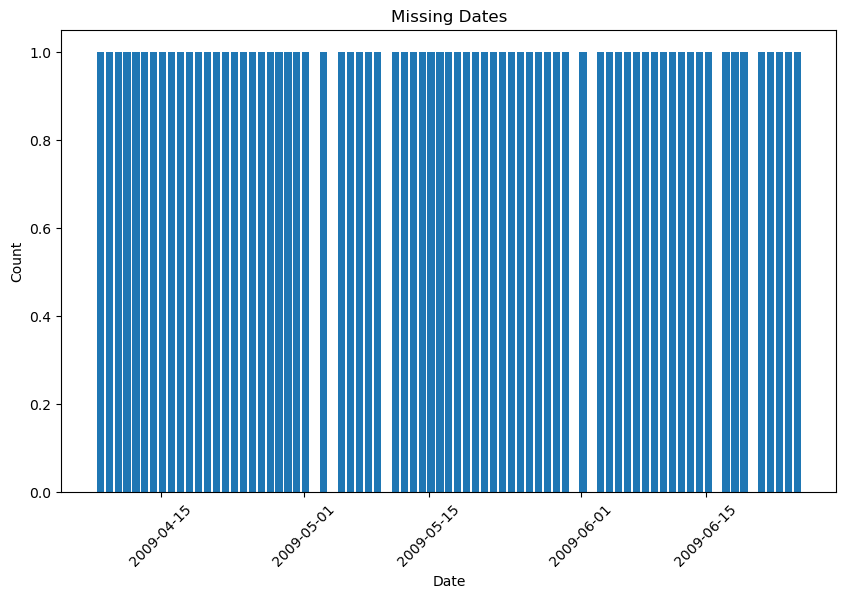

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [96]:
#Check shape of the df_copy after interporlation
df_copy.shape

(1598199, 2)

In [97]:
#Checking for missing data after interpolation
df_copy.isnull().sum()


textblob_sentiment    72
label_encoded          0
dtype: int64

# Filling the missing values generated after interpolation with modal class of each week

In [98]:
df_copy.head(5)

textblob_sentiment  label_encoded
date                                                 
2009-04-07 05:19:45           Positive            2.0
2009-04-07 05:19:49            Neutral            1.0
2009-04-07 05:19:53           Positive            2.0
2009-04-07 05:19:57           Positive            2.0
2009-04-07 05:19:57           Negative            0.0

In [99]:
df_copy = df_copy.reset_index()

# Check if the index has been reset
print(df_copy.head(5))

                 date textblob_sentiment  label_encoded
0 2009-04-07 05:19:45           Positive            2.0
1 2009-04-07 05:19:49            Neutral            1.0
2 2009-04-07 05:19:53           Positive            2.0
3 2009-04-07 05:19:57           Positive            2.0
4 2009-04-07 05:19:57           Negative            0.0


In [100]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598199 entries, 0 to 1598198
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598199 non-null  datetime64[ns]
 1   textblob_sentiment  1598127 non-null  object        
 2   label_encoded       1598199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.6+ MB


In [101]:
import pandas as pd

# Function to impute missing textblob_sentiment values by week
def impute_sentiment_by_week(df_copy):
    mode_sentiments = df_copy.groupby(df_copy['date'].dt.isocalendar().week)['textblob_sentiment'].apply(lambda x: x.mode()[0])
    df_copy['textblob_sentiment'] = df_copy['textblob_sentiment'].fillna(df_copy['date'].dt.isocalendar().week.map(mode_sentiments))
    return df_copy

# Apply function to impute missing textblob_sentiment values
df_copy = df_copy.groupby(df_copy['date'].dt.year, group_keys=True).apply(impute_sentiment_by_week)

print(df_copy)



                            date textblob_sentiment  label_encoded
date                                                              
2009 0       2009-04-07 05:19:45           Positive            2.0
     1       2009-04-07 05:19:49            Neutral            1.0
     2       2009-04-07 05:19:53           Positive            2.0
     3       2009-04-07 05:19:57           Positive            2.0
     4       2009-04-07 05:19:57           Negative            0.0
...                          ...                ...            ...
     1598194 2009-06-21 05:19:45            Neutral            2.0
     1598195 2009-06-22 05:19:45            Neutral            2.0
     1598196 2009-06-23 05:19:45            Neutral            2.0
     1598197 2009-06-24 05:19:45            Neutral            2.0
     1598198 2009-06-25 05:19:45            Neutral            2.0

[1598199 rows x 3 columns]


In [102]:
#Checking for missing data after interpolation
df_copy.isnull().sum()

date                  0
textblob_sentiment    0
label_encoded         0
dtype: int64

In [103]:
df_copy.head(5)

date textblob_sentiment  label_encoded
date                                                        
2009 0 2009-04-07 05:19:45           Positive            2.0
     1 2009-04-07 05:19:49            Neutral            1.0
     2 2009-04-07 05:19:53           Positive            2.0
     3 2009-04-07 05:19:57           Positive            2.0
     4 2009-04-07 05:19:57           Negative            0.0

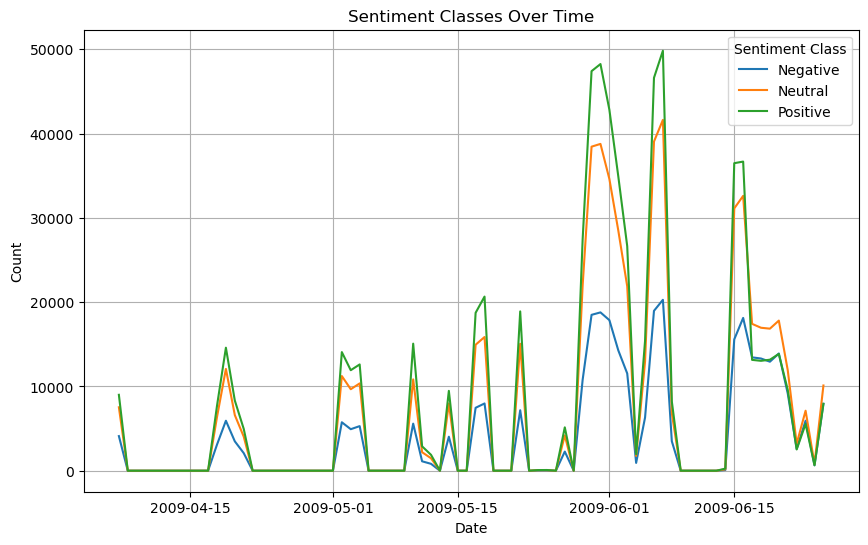

In [104]:
# Set 'date' back to index
df_copy = df_copy.set_index('date')

# Plot time series of sentiment classes
plt.figure(figsize=(10, 6))

# Group by sentiment classes and count occurrences for each date
sentiment_counts = df_copy.groupby([df_copy.index.date, 'textblob_sentiment']).size().unstack(fill_value=0)

# Plot each sentiment class
for sentiment_class in sentiment_counts.columns:
    plt.plot(sentiment_counts.index, sentiment_counts[sentiment_class], label=sentiment_class)

plt.title('Sentiment Classes Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Class')
plt.grid(True)
plt.show()


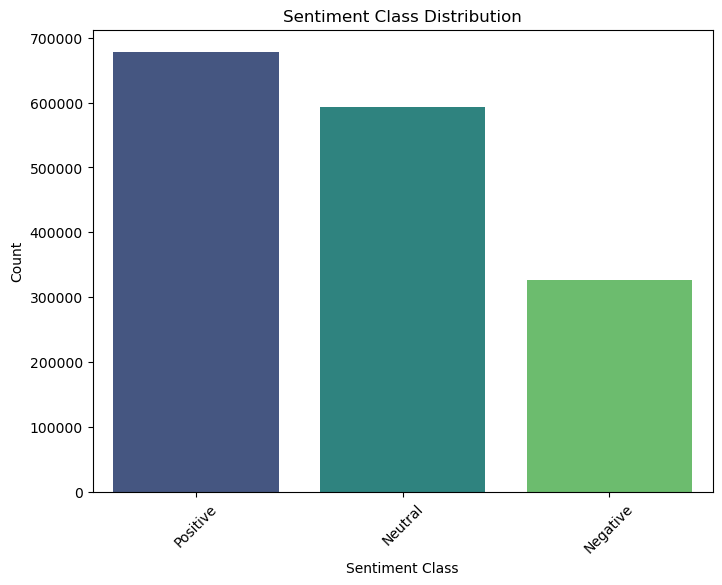

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment class
sentiment_counts = df_copy['textblob_sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import numpy as np

In [108]:
df_copy.head(5)

date textblob_sentiment  label_encoded
0 2009-04-07 05:19:45           Positive            2.0
1 2009-04-07 05:19:49            Neutral            1.0
2 2009-04-07 05:19:53           Positive            2.0
3 2009-04-07 05:19:57           Positive            2.0
4 2009-04-07 05:19:57           Negative            0.0

In [114]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598199 entries, 0 to 1598198
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598199 non-null  datetime64[ns]
 1   textblob_sentiment  1598199 non-null  object        
 2   label_encoded       1598199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.6+ MB


In [115]:
# Aggregate data for each day
df_grouped = df_copy.groupby([df_copy['date'].dt.date, 'textblob_sentiment']).size().unstack(fill_value=0)

# Reset index to convert 'date' back to a column
df_grouped = df_grouped.reset_index()

In [116]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      80 non-null     object
 1   Negative  80 non-null     int64 
 2   Neutral   80 non-null     int64 
 3   Positive  80 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.6+ KB


In [118]:
df_grouped.head(5)

textblob_sentiment  Negative  Neutral  Positive
date                                           
2009-04-07              4109     7526      9008
2009-04-08                 0        0         1
2009-04-09                 0        0         1
2009-04-10                 0        0         1
2009-04-11                 0        0         1

In [117]:
# Resample data to daily frequency

df_resampled = df_grouped.resample('D').ffill()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [111]:
print(df_grouped)

textblob_sentiment  Negative  Neutral  Positive
date                                           
2009-04-07              4109     7526      9008
2009-04-08                 0        0         1
2009-04-09                 0        0         1
2009-04-10                 0        0         1
2009-04-11                 0        0         1
...                      ...      ...       ...
2009-06-21              9161    11921      9595
2009-06-22              2588     3200      2523
2009-06-23              5937     7120      5545
2009-06-24               647      805       642
2009-06-25              7942    10113      7937

[80 rows x 3 columns]


In [112]:
df_grouped.set_index('date', inplace=True)

KeyError: "None of ['date'] are in the columns"

In [145]:
# Reset index to convert 'date' back to a column
df_grouped = df_grouped.reset_index()

In [146]:
# Resample data to daily frequency
df_grouped.set_index('date', inplace=True)
df_resampled = df_grouped.resample('D').ffill()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
# Calculate class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df_resampled['label_encoded']), y=df_resampled['label_encoded'])

In [ ]:
# Split data into features and target
X = df_resampled.drop(columns=['textblob_sentiment', 'label_encoded'])
y = df_resampled['label_encoded']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM

In [ ]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model with class weights
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model with class weights
model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=100, batch_size=32, class_weight=class_weights, validation_data=(np.expand_dims(X_test, axis=2), y_test), callbacks=[EarlyStopping(patience=5)])


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=2), y_test)
print("Test Accuracy:", accuracy)

In [137]:

# Reset index to convert 'date' back to a column
df_grouped = df_grouped.reset_index()

# Resample data to daily frequency
df_grouped.set_index('date', inplace=True)
df_resampled = df_grouped.resample('D').ffill()

# Encode 'textblob_sentiment' using LabelEncoder
label_encoder = LabelEncoder()
df_resampled['label_encoded'] = label_encoder.fit_transform(df_resampled['textblob_sentiment'])

# Calculate class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df_resampled['label_encoded']), y=df_resampled['label_encoded'])

# Split data into features and target
X = df_resampled.drop(columns=['textblob_sentiment', 'label_encoded'])
y = df_resampled['label_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with class weights
model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=100, batch_size=32, class_weight=class_weights, validation_data=(np.expand_dims(X_test, axis=2), y_test), callbacks=[EarlyStopping(patience=5)])

# Evaluate the model
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=2), y_test)
print("Test Accuracy:", accuracy)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [133]:
# Resample data to daily frequency
df_resampled = df_copy.resample('D').ffill()

ValueError: cannot reindex a non-unique index with a method or limit

In [ ]:




# Encode 'textblob_sentiment' using LabelEncoder
label_encoder = LabelEncoder()
df_resampled['label_encoded'] = label_encoder.fit_transform(df_resampled['textblob_sentiment'])

# Calculate class weights for handling class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df_resampled['label_encoded']), y=df_resampled['label_encoded'])

# Split data into features and target
X = df_resampled.drop(columns=['textblob_sentiment', 'label_encoded'])
y = df_resampled['label_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with class weights
model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=100, batch_size=32, class_weight=class_weights, validation_data=(np.expand_dims(X_test, axis=2), y_test), callbacks=[EarlyStopping(patience=5)])

# Evaluate the model
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=2), y_test)
print("Test Accuracy:", accuracy)


In [129]:
df_copy.head(5)

textblob_sentiment  label_encoded
date                                                 
2009-04-07 05:19:45           Positive            2.0
2009-04-07 05:19:49            Neutral            1.0
2009-04-07 05:19:53           Positive            2.0
2009-04-07 05:19:57           Positive            2.0
2009-04-07 05:19:57           Negative            0.0

In [108]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# handling class imbalance of textblob sentiment

In [109]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Check class distribution
class_distribution = df_copy['textblob_sentiment'].value_counts()
print("Class distribution before oversampling:")
print(class_distribution)


Class distribution before oversampling:
Positive    678483
Neutral     593056
Negative    326588
Name: textblob_sentiment, dtype: int64


In [110]:
# Reset index to have 'date' as a column
df_reset = df_copy.reset_index()

In [221]:
df_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598199 entries, 0 to 1598198
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1598199 non-null  datetime64[ns]
 1   textblob_sentiment  1598127 non-null  object        
 2   label_encoded       1598199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.6+ MB


In [225]:
from statsmodels.tsa.seasonal import seasonal_decompose
df1 = df_reset.set_index('date')
results = seasonal_decompose(df1['label_encoded'])
results.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [222]:
# Oversample to address class imbalance
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(df_reset[['date']], df_reset['label_encoded'])

In [224]:
# Convert resampled data back to DataFrame
df_resampled = pd.DataFrame({'date': X_resampled, 'label_encoded': y_resampled})

# Set 'date' column back as index
df_resampled.set_index('date', inplace=True)

ValueError: Data must be 1-dimensional

In [ ]:
# Check class distribution after oversampling
class_distribution_resampled = df_resampled['textblob_sentiment'].value_counts()
print("\nClass distribution after oversampling:")
print(class_distribution_resampled)

In [208]:
df2 = df_copy.copy()

In [209]:
df2.head(5)

textblob_sentiment  label_encoded
date                                                 
2009-04-07 05:19:45           Positive            2.0
2009-04-07 05:19:49            Neutral            1.0
2009-04-07 05:19:53           Positive            2.0
2009-04-07 05:19:57           Positive            2.0
2009-04-07 05:19:57           Negative            0.0

In [217]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Check class distribution
class_distribution = df2['textblob_sentiment'].value_counts()
print("Class distribution before oversampling:")
print(class_distribution)



Class distribution before oversampling:
Positive    678483
Neutral     593056
Negative    326588
Name: textblob_sentiment, dtype: int64


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# Oversample to address class imbalance
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(df.index.values.reshape(-1, 1), df2['textblob_sentiment'])

In [ ]:
# Convert resampled data back to DataFrame
df_resampled = pd.DataFrame({'date': X_resampled.flatten(), 'textblob_sentiment': y_resampled})

# Check class distribution after oversampling
class_distribution_resampled = df_resampled['textblob_sentiment'].value_counts()
print("\nClass distribution after oversampling:")
print(class_distribution_resampled)

In [210]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [211]:
# Define a function to prepare data for LSTM
def prepare_lstm_data(df2):
    label_encoder = LabelEncoder()
    df2['label_encoded'] = label_encoder.fit_transform(df2['textblob_sentiment'])
    X = df2.index.values.reshape(-1, 1)  # Feature: date index
    y = df2['label_encoded'].values       # Target: sentiment label
    return X, y, label_encoder

In [212]:
# Prepare data for LSTM
X_lstm, y_lstm, label_encoder_lstm = prepare_lstm_data(df2)

In [213]:
# Resample to address class imbalance
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_lstm, y_lstm)

In [214]:
# Split data into train and test sets for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [216]:
X_train_lstm.shape, X_test_lstm.shape

((2171145, 1), (542787, 1))

In [215]:
# Define and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(len(label_encoder_lstm.classes_), activation='softmax'))  # Softmax for multiclass classification
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [ ]:









# Define a function to prepare data for ARIMA and SARIMA
def prepare_arima_data(df):
    # Group by date and count occurrences of each sentiment
    sentiment_counts = df.groupby([df.index.date, 'textblob_sentiment']).size().unstack(fill_value=0)
    # Aggregate counts to daily level
    sentiment_counts_daily = sentiment_counts.sum(axis=1)
    return sentiment_counts_daily

# Prepare data for ARIMA and SARIMA
sentiment_counts_daily = prepare_arima_data(df)

# Train ARIMA model
arima_model = ARIMA(sentiment_counts_daily, order=(5, 1, 0))
arima_results = arima_model.fit()

# Train SARIMA model
sarima_model = SARIMAX(sentiment_counts_daily, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

# Forecast sentiments for day 1, 3, and 7 using LSTM, ARIMA, and SARIMA
day_1_forecast_lstm = lstm_model.predict(np.array([[1]]))
day_3_forecast_lstm = lstm_model.predict(np.array([[3]]))
day_7_forecast_lstm = lstm_model.predict(np.array([[7]]))

day_1_forecast_arima = arima_results.forecast(steps=1)
day_3_forecast_arima = arima_results.forecast(steps=3)
day_7_forecast_arima = arima_results.forecast(steps=7)

day_1_forecast_sarima = sarima_results.forecast(steps=1)
day_3_forecast_sarima = sarima_results.forecast(steps=3)
day_7_forecast_sarima = sarima_results.forecast(steps=7)


In [ ]:
# Prepare data
X = df.index.values.reshape(-1, 1)  # Feature: date index
y = df['label_encoded'].values       # Target: sentiment label

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Resample to address class imbalance
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
# Define and train LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_resampled.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Softmax for multiclass classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32)

In [ ]:
# Define and train ARIMA model
def fit_arima_model(train_data, order):
    model = ARIMA(train_data, order=order)
    fitted_model = model.fit()
    return fitted_model

arima_model = fit_arima_model(y_train, order=(5, 1, 0))

In [ ]:
# Define and train SARIMA model
def fit_sarima_model(train_data, order, seasonal_order):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

sarima_model = fit_sarima_model(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

In [ ]:
# Make predictions using LSTM model
y_pred_lstm = model.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)  # Get predicted classes

# Make predictions using ARIMA model
y_pred_arima = arima_model.forecast(steps=len(X_test))

# Make predictions using SARIMA model
y_pred_sarima = sarima_model.forecast(steps=len(X_test))

In [ ]:
# Evaluate the LSTM model
print("LSTM Model:")
print(classification_report(y_test, y_pred_classes_lstm, target_names=label_encoder.classes_))


In [108]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [109]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Convert class labels to one-hot encoded vectors
onehot_encoder = OneHotEncoder()
y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_encoded = onehot_encoder.transform(y_test.values.reshape(-1, 1)).toarray()


ValueError: Found unknown categories [nan] in column 0 during transform

In [ ]:



# Calculate class weights to handle imbalance
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / class_counts[i] for i in range(len(class_counts))}

# Define and compile the RNN model with weighted cross-entropy loss
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with three units for three classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multiple classes
              metrics=['accuracy'])

# Train the model with weighted loss
model.fit(X_train, y_train_encoded, epochs=10, class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


# LSTM for sentiment analysis with imbalanced data
The steps to be considered include:-

- Preprocess the text data- i am using already preprocessed text data
- Tokenize the preprocessed data
- Prepare data for training
- split the data into training and test set
- define and train the LSTM model
- Evaluate the model

In [79]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split

# Visualize the trends of the sentiments

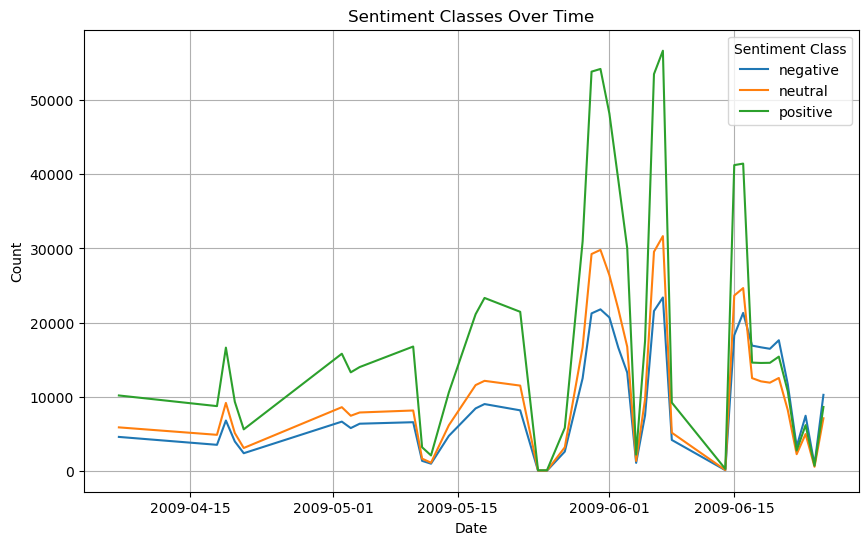

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Set 'date' column as index
df.set_index('date', inplace=True)

# Plot time series of sentiment classes
plt.figure(figsize=(10, 6))

# Group by sentiment classes and count occurrences for each date
sentiment_counts = df.groupby([df.index.date, 'sentiment_vader']).size().unstack(fill_value=0)

# Plot each sentiment class
for sentiment_class in sentiment_counts.columns:
    plt.plot(sentiment_counts.index, sentiment_counts[sentiment_class], label=sentiment_class)

plt.title('Sentiment Classes Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment Class')
plt.grid(True)
plt.show()


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600000 entries, 2009-04-07 05:19:45 to NaT
Data columns (total 33 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   text                1598127 non-null  object 
 1   user                1598127 non-null  object 
 2   day                 1598127 non-null  float64
 3   month               1598127 non-null  float64
 4   word_count          1598127 non-null  float64
 5   char_count          1598127 non-null  float64
 6   avg_word            1598127 non-null  float64
 7   stopwords           1598127 non-null  float64
 8   hashtags            1598127 non-null  float64
 9   at_sign             1598127 non-null  float64
 10  numerics            1598127 non-null  float64
 11  upper               1598127 non-null  float64
 12  text1               1598127 non-null  object 
 13  tokenized_text      1598127 non-null  object 
 14  preprocessed_text   1598127 non-null  object 
 15

# Findings from EDA
- The date variable has duplicate indices for some observations, the dates are similar but not duplicacte in terms of observations
- The sentiments have class imbalance

# LSTM MODEL FOR FORECASTING OF THE SENTIMENTS
- With unbalanced data (vader vs textblob, label encoded, one-hot encoded)
- With balanced data (vader vs textblob, label encoded, one hot encoded)

## 1. Unbalanced class from Vader sentiment when data is label encoded

Check the maximum length of the texts

In [82]:
#Calculate the maximum length of the text
max_len = max([len(str(text)) for text in df['preprocessed_text']])

print("Maximum sequence length:", max_len)

Maximum sequence length: 179


In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [84]:
# Define X (features) and y (labels)
X = df['tokenized_text'] 
y = df['label_text_encoded']

In [87]:
X.shape, y.shape

((1600000,), (1600000,))

In [88]:
X.head(5)

date
2009-04-07 05:19:45    awww thats bummer shoulda got david carr third...
2009-04-07 05:19:49    upset cant update facebook texting might cry r...
2009-04-07 05:19:53    dived many times ball managed save rest go bounds
2009-04-07 05:19:57                     whole body feels itchy like fire
2009-04-07 05:19:57                             behaving im mad cant see
Name: tokenized_text, dtype: object

In [90]:
X.isnull().sum()

1873

In [91]:
df.isnull().sum()

text                  1873
user                  1873
day                   1873
month                 1873
word_count            1873
char_count            1873
avg_word              1873
stopwords             1873
hashtags              1873
at_sign               1873
numerics              1873
upper                 1873
text1                 1873
tokenized_text        1873
preprocessed_text     1873
polarity_score        1873
textblob_sentiment    1873
textblobsentiment     1873
vader_sentiment       1873
vader_neg             1873
vader_neu             1873
vader_pos             1873
vader_compound        1873
sentiment_vader       1873
label_text_encoded    1873
vader_encoded         1873
Negative              1873
Neutral               1873
Positive              1873
negative                 1
neutral                  1
positive                 1
NaN                      1
dtype: int64

In [89]:
#Pad the tokenized text
max_len = 37  # Define maximum sequence length
X = pad_sequences(X, maxlen=max_len, padding='post')

ValueError: `sequences` must be a list of iterables. Found non-iterable: nan

In [ ]:






# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LSTM model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 categories for sentiment classification

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Forecasting sentiment for day 1, 3, and 7
# Assuming you have the tokenized and encoded data for day 1, 3, and 7
day1_data = pad_sequences(day1_tokenized_text, maxlen=max_len, padding='post')
day3_data = pad_sequences(day3_tokenized_text, maxlen=max_len, padding='post')
day7_data = pad_sequences(day7_tokenized_text, maxlen=max_len, padding='post')

# Predict sentiment for day 1, 3, and 7
day1_sentiment = model.predict_classes(day1_data)
day3_sentiment = model.predict_classes(day3_data)
day7_sentiment = model.predict_classes(day7_data)

print("Sentiment for day 1:", day1_sentiment)
print("Sentiment for day 3:", day3_sentiment)
print("Sentiment for day 7:", day7_sentiment)


In [92]:
#Select specific columns from the original DataFrame
LSTM_data = df[['preprocessed_text', 'sentiment_vader', 'textblob_sentiment', 'label_text_encoded', 'vader_encoded']]

# Display the first 5 rows of the new DataFrame
print(LSTM_data.head(5))

                                                     preprocessed_text  \
date                                                                     
2009-04-07 05:19:45  awww thats bummer shoulda got david carr third...   
2009-04-07 05:19:49  upset cant update facebook texting might cry r...   
2009-04-07 05:19:53  dived many time ball managed save 50 rest go b...   
2009-04-07 05:19:57                    whole body feel itchy like fire   
2009-04-07 05:19:57                           behaving im mad cant see   

                    sentiment_vader textblob_sentiment  label_text_encoded  \
date                                                                         
2009-04-07 05:19:45        negative           Positive                 2.0   
2009-04-07 05:19:49        negative            Neutral                 1.0   
2009-04-07 05:19:53        positive           Positive                 2.0   
2009-04-07 05:19:57        negative           Positive                 2.0   
2009-04-07 05

In [89]:
from keras.preprocessing.text import Tokenizer

# Create a Tokenizer instance
tokenizer = Tokenizer()

#Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['preprocessed_text'])

#Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for <UNK> token

#Maximum sequence length
max_len = max([len(seq.split()) for seq in df['preprocessed_text']])

print("Maximum vocabulary size:", vocab_size)
print("Maximum sequence length:", max_len)


AttributeError: 'float' object has no attribute 'lower'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


#Prepare the data
X = df['preprocessed_text']  # Input features
y = df['label_text_encoded']  # Labels

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Define the LSTM model architecture
vocab_size = 10000  # Adjust as per your vocabulary size
max_len = 100  # Adjust as per your maximum sequence length

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
# Tokenize and pad sequences
# Example tokenization and padding:
# tokenizer = Tokenizer(num_words=vocab_size)
# tokenizer.fit_on_texts(X_train)
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)
# X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
# X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Since tokenization and padding process is not shown, you need to perform it as per your data preprocessing
# You can uncomment and adjust the above lines accordingly

# Example training:
# model.fit(X_train_pad, y_train, epochs=5, batch_size=32)

# Step 6: Evaluate the model
# Example evaluation:
# loss, accuracy = model.evaluate(X_test_pad, y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

# After training and evaluation, you can use this model to predict sentiments on new data


# TIME SERIES ANALYSIS

### STL Decomposition

In [87]:
#filter the date and sentiment to plot the graph
stl_data = df[['label_text_encoded']]
stl_data.head(5)

label_text_encoded
date                                   
2009-04-07 05:19:45                 2.0
2009-04-07 05:19:49                 1.0
2009-04-07 05:19:53                 2.0
2009-04-07 05:19:57                 2.0
2009-04-07 05:19:57                 0.0

## Multiplicative

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Decompose the data
decomposed_data = seasonal_decompose(stl_data, model = 'multiplicative')

#plot decomposed data
decomposed_data.plot()

#Display the plot
plt.show()

ValueError: This function does not handle missing values

## Additive

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Decompose the data
decomposed_data = seasonal_decompose(stl_data, model = 'additive')

#plot decomposed data
decomposed_data.plot()

#Display the plot
plt.show()

# LSTM FOR TEXTBLOB SENTIMENT

In [120]:
# Hyperparameters 
max_words = 1000 # max number of words to use in the vocabulary
max_len = 37 # max length of each text (in terms of number of words)
embedding_dim = 100 # dimension of word embeddings
lstm_units = 64 # number of units in the LSTM layer
num_classes = len(set(df['vader_encoded'])) # number of classes


In [ ]:
import keras.preprocessing.text Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [119]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Define window size for LSTM model
window_size = 7  

# Convert dataset into sequences of fixed length
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Create sequences for LSTM model
X, y = create_sequences(df['vader_encoded'], window_size)

# Convert sentiment labels to categorical format
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define LSTM model
model = Sequential([
    LSTM(units=64, input_shape=(window_size, 1)),
    Dropout(0.2),
    Dense(units=len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


C:\Users\Diana\anaconda3\Lib\site-packages\keras\src\utils\np_utils.py:62: RuntimeWarning: invalid value encountered in cast
  y = np.array(y, dtype="int")


IndexError: index -2147483648 is out of bounds for axis 1 with size 3

In [118]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Resample data to daily frequency
time_series_data = df.resample('D')['vader_encoded'].mean()

# Split the data into train and test sets
train_size = int(len(time_series_data) * 0.8)
train_data, test_data = time_series_data[:train_size], time_series_data[train_size:]

# Train ARIMA model
model = ARIMA(train_data, order=(5,1,0))
arima_model = model.fit()

# Make predictions
forecast_1day = arima_model.forecast(steps=1)[0][0]
forecast_3days = arima_model.forecast(steps=3)[0][-1]
forecast_7days = arima_model.forecast(steps=7)[0][-1]

print("Forecast for 1 day ahead:", forecast_1day)
print("Forecast for 3 days ahead:", forecast_3days)
print("Forecast for 7 days ahead:", forecast_7days)


C:\Users\Diana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Diana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Diana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


IndexError: invalid index to scalar variable.